<a href="https://www.kaggle.com/code/ampiiere/animal-crossing-villager-popularity-analysis?scriptVersionId=102414432" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns  # data visualization
import matplotlib.pyplot as plt


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/acnh-villager-popularity/acnh_villager_data.csv
/kaggle/input/animal-crossing-new-horizons-nookplaza-dataset/construction.csv
/kaggle/input/animal-crossing-new-horizons-nookplaza-dataset/bottoms.csv
/kaggle/input/animal-crossing-new-horizons-nookplaza-dataset/accessories.csv
/kaggle/input/animal-crossing-new-horizons-nookplaza-dataset/insects.csv
/kaggle/input/animal-crossing-new-horizons-nookplaza-dataset/floors.csv
/kaggle/input/animal-crossing-new-horizons-nookplaza-dataset/shoes.csv
/kaggle/input/animal-crossing-new-horizons-nookplaza-dataset/wall-mounted.csv
/kaggle/input/animal-crossing-new-horizons-nookplaza-dataset/achievements.csv
/kaggle/input/animal-crossing-new-horizons-nookplaza-dataset/umbrellas.csv
/kaggle/input/animal-crossing-new-horizons-nookplaza-dataset/rugs.csv
/kaggle/input/animal-crossing-new-horizons-nookplaza-dataset/housewares.csv
/kaggle/input/animal-crossing-new-horizons-nookplaza-dataset/art.csv
/kaggle/input/animal-crossing-new-horizons-nookp

# Introduction
The goal of this project is to analyse the relationship between animal crossing new horizon villager popularity amongst the player base and certain villager attributes. 

We will be analysing the Gender,Personality, Species, and Style of a villager. 

# Data Initilization and Cleaning

In [2]:
vlgr_df = pd.read_csv("/kaggle/input/animal-crossing-new-horizons-nookplaza-dataset/villagers.csv")
popul_df = pd.read_csv("/kaggle/input/acnh-villager-popularity/acnh_villager_data.csv")

In [3]:
vlgr_df.head()

,Name,Species,Gender,Personality,Hobby,Birthday,Catchphrase,Favorite Song,Style 1,Style 2,Color 1,Color 2,Wallpaper,Flooring,Furniture List,Filename,Unique Entry ID
0,Admiral,Bird,Male,Cranky,Nature,27-Jan,aye aye,Steep Hill,Cool,Cool,Black,Blue,dirt-clod wall,tatami,717;1849;7047;2736;787;5970;3449;3622;3802;410...,brd06,B3RyfNEqwGmcccRC3
1,Agent S,Squirrel,Female,Peppy,Fitness,2-Jul,sidekick,Go K.K. Rider,Active,Simple,Blue,Black,concrete wall,colorful tile flooring,7845;7150;3468;4080;290;3971;3449;1708;4756;25...,squ05,SGMdki6dzpDZyXAw5
2,Agnes,Pig,Female,Big Sister,Play,21-Apr,snuffle,K.K. House,Simple,Elegant,Pink,White,gray molded-panel wall,arabesque flooring,4129;7236;7235;7802;896;3428;4027;7325;3958;71...,pig17,jzWCiDPm9MqtCfecP
3,Al,Gorilla,Male,Lazy,Fitness,18-Oct,ayyyeee,Go K.K. Rider,Active,Active,Red,White,concrete wall,green rubber flooring,1452;4078;4013;833;4116;3697;7845;3307;3946;39...,gor08,LBifxETQJGEaLhBjC
4,Alfonso,Alligator,Male,Lazy,Play,9-Jun,it'sa me,Forest Life,Simple,Simple,Red,Blue,yellow playroom wall,green honeycomb tile,4763;3205;3701;1557;3623;85;3208;3584;4761;121...,crd00,REpd8KxB8p9aGBRSE


In [4]:
popul_df.head()

,tier,rank,name
0,1,1,Raymond
1,1,2,Marshal
2,1,3,Shino
3,1,4,Sherb
4,1,5,Sasha


### 1. Checking for null 

In [5]:
vlgr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391 entries, 0 to 390
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Name             391 non-null    object
 1   Species          391 non-null    object
 2   Gender           391 non-null    object
 3   Personality      391 non-null    object
 4   Hobby            391 non-null    object
 5   Birthday         391 non-null    object
 6   Catchphrase      391 non-null    object
 7   Favorite Song    391 non-null    object
 8   Style 1          391 non-null    object
 9   Style 2          391 non-null    object
 10  Color 1          391 non-null    object
 11  Color 2          391 non-null    object
 12  Wallpaper        391 non-null    object
 13  Flooring         391 non-null    object
 14  Furniture List   391 non-null    object
 15  Filename         391 non-null    object
 16  Unique Entry ID  391 non-null    object
dtypes: object(17)
memory usage: 52.1+ K

In [6]:
popul_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413 entries, 0 to 412
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tier    413 non-null    int64 
 1   rank    413 non-null    int64 
 2   name    413 non-null    object
dtypes: int64(2), object(1)
memory usage: 9.8+ KB


### 2. Checking for mismatched names

In [7]:
# There are some missing/non-matching names 
vlgr_df["Name"].isin(popul_df['name']).sum()

386

In [8]:
# vlgr_df does not have these names...
mismatch_names = popul_df["name"][popul_df["name"].isin(vlgr_df["Name"]) == False]
mismatch_names

2               Shino
4               Sasha
5                Ione
25         Cephalobot
57             Étoile
84          Tiansheng
105             Petri
108             Quinn
114             Marlo
116              Chai
146            Azalea
158             Faith
170          Chabwick
202            WartJr
212               Rio
216       Buck(Brows)
222             Renee
224           Chelsea
226             Marty
229           Roswell
261               Zoe
287             OHare
300    Crackle(Spork)
323               Ace
328              Toby
341             Frett
399             Rilla
Name: name, dtype: object

In [9]:
# Data set is small enough to pick out the same names
# Correcting names in popul_df to match vlgr_df
popul_df['name'] = popul_df['name'].replace(['OHare'],"O\'Hare")
popul_df['name'] = popul_df['name'].replace(['Buck(Brows)'],"Buck")
popul_df['name'] = popul_df['name'].replace(['Renee'],"Renée")
popul_df['name'] = popul_df['name'].replace(['WartJr'],"Wart Jr.")
popul_df['name'] = popul_df['name'].replace(['Crackle(Spork)'],"Spork")

In [10]:
# Checking if All names match
vlgr_df["Name"].isin(popul_df['name']).sum()

391

In [11]:
# drop villagers that are in popul_df but not in vlgr_df
popul_df = popul_df.drop(popul_df[popul_df["name"].isin(vlgr_df["Name"]) == False].index)

### 3. Merging the two Dataframes

In [12]:
# Now that both df have same length, we can set index as names and combine the 2 dfs
popul_df.set_index('name', drop=True, inplace=True)
vlgr_df.set_index('Name', drop=True, inplace=True)

In [13]:
combined_df = popul_df.merge(vlgr_df, left_index=True, right_index=True)

In [14]:
# drop irrelevent columns
combined_df.drop(columns=['Furniture List', 'Filename', 'Unique Entry ID', "Wallpaper", "Flooring", "Birthday", "Favorite Song"], inplace=True)

#### Adding a new row named overall_ranking so we may know a villager's general ranking outside of their tier

In [15]:
combined_df.sort_values(['tier', 'rank'], inplace=True)
combined_df['overall_ranking'] = np.arange(1, len(combined_df)+1)
combined_df.insert(2, 'overall_ranking', combined_df.pop('overall_ranking'))

#### Setting Baseline overall ranking mean to compare against

In [16]:
overall_mean = combined_df.overall_ranking.mean()
print(f'The overall_mean is {overall_mean}, this would serve as a baseline for to compare against popularity performance of our features.')

The overall_mean is 196.0, this would serve as a baseline for to compare against popularity performance of our features.


In [17]:
combined_df.columns

Index(['tier', 'rank', 'overall_ranking', 'Species', 'Gender', 'Personality',
       'Hobby', 'Catchphrase', 'Style 1', 'Style 2', 'Color 1', 'Color 2'],
      dtype='object')

# Exploratory Data Analysis
As a preface, a higher overall_ranking would mean performing worse on the popularity rankings.
### 1. Gender

In [18]:
combined_df['Gender'].value_counts()

Male      204
Female    187
Name: Gender, dtype: int64

<AxesSubplot:ylabel='tier,Gender'>

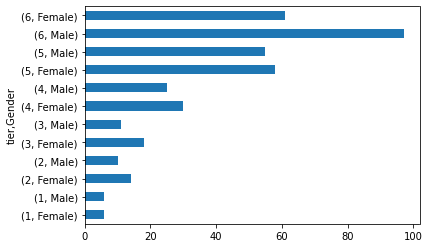

In [19]:
combined_df.groupby('tier').Gender.value_counts().plot.barh()

For gender, there seems to be a disproporationate amount of male villagers in the lowest tier(6th tier) than female villagers, compared to other tiers. Discounting Tier 6, The number of male and female villagers are fairly even, with Male villagers having a slight lead in all tiers(except tier 6).

<AxesSubplot:xlabel='Gender', ylabel='overall_ranking'>

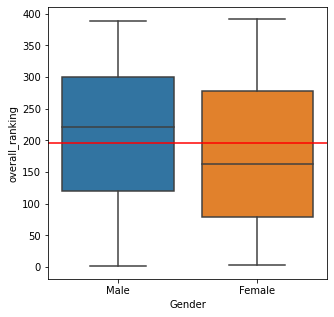

In [20]:
plt.figure(figsize=(5, 5))
plt.axhline(overall_mean, color='r')
sns.boxplot(x="Gender", y='overall_ranking', data=combined_df)

Female villagers generally perform better than Male villagers in terms of overall ranking. 

In [21]:
pd.pivot_table(combined_df, index = 'tier', values = 'Catchphrase', columns="Gender", aggfunc='count')

Gender,Female,Male
tier,,
1,6,6
2,14,10
3,18,11
4,30,25
5,58,55
6,61,97


### 2. Species

In [22]:
# creating value counts dataframe for each species type
species_ranking = combined_df.groupby('Species').mean()['overall_ranking'].to_frame().reset_index().sort_values('overall_ranking')
species_ranking

,Species,overall_ranking
25,Octopus,17.333333
9,Deer,52.300000
34,Wolf,72.636364
5,Cat,94.521739
21,Koala,134.111111
10,Dog,139.750000
8,Cub,143.187500
17,Hamster,147.250000
32,Squirrel,148.611111
30,Rhino,155.333333


<AxesSubplot:xlabel='Species', ylabel='overall_ranking'>

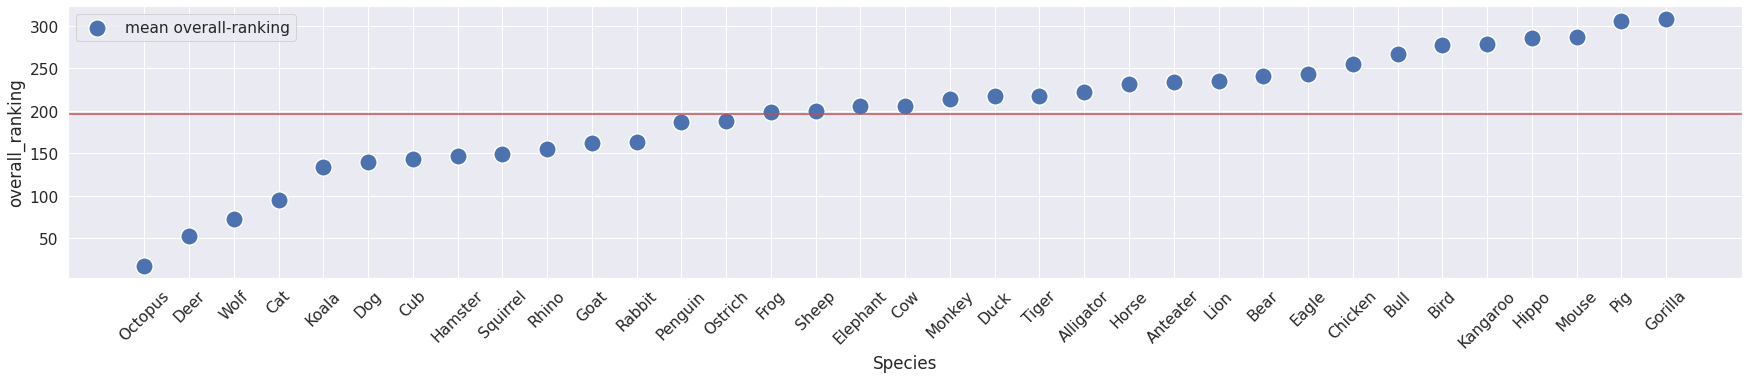

In [23]:
plt.figure(figsize=(30,5))
sns.set(font_scale=1.4)
plt.xticks(rotation=45)
plt.axhline(overall_mean, color='r')
sns.scatterplot(x='Species', y="overall_ranking", data=species_ranking,label='mean overall-ranking', s=300)

Octopus, deer, wolves, cats and Koalas are most likely to be popular; while Kangaroos, Hippos, Mouse Pigs and Gorillas are the least likely to be popular. 

<AxesSubplot:xlabel='Species', ylabel='overall_ranking'>

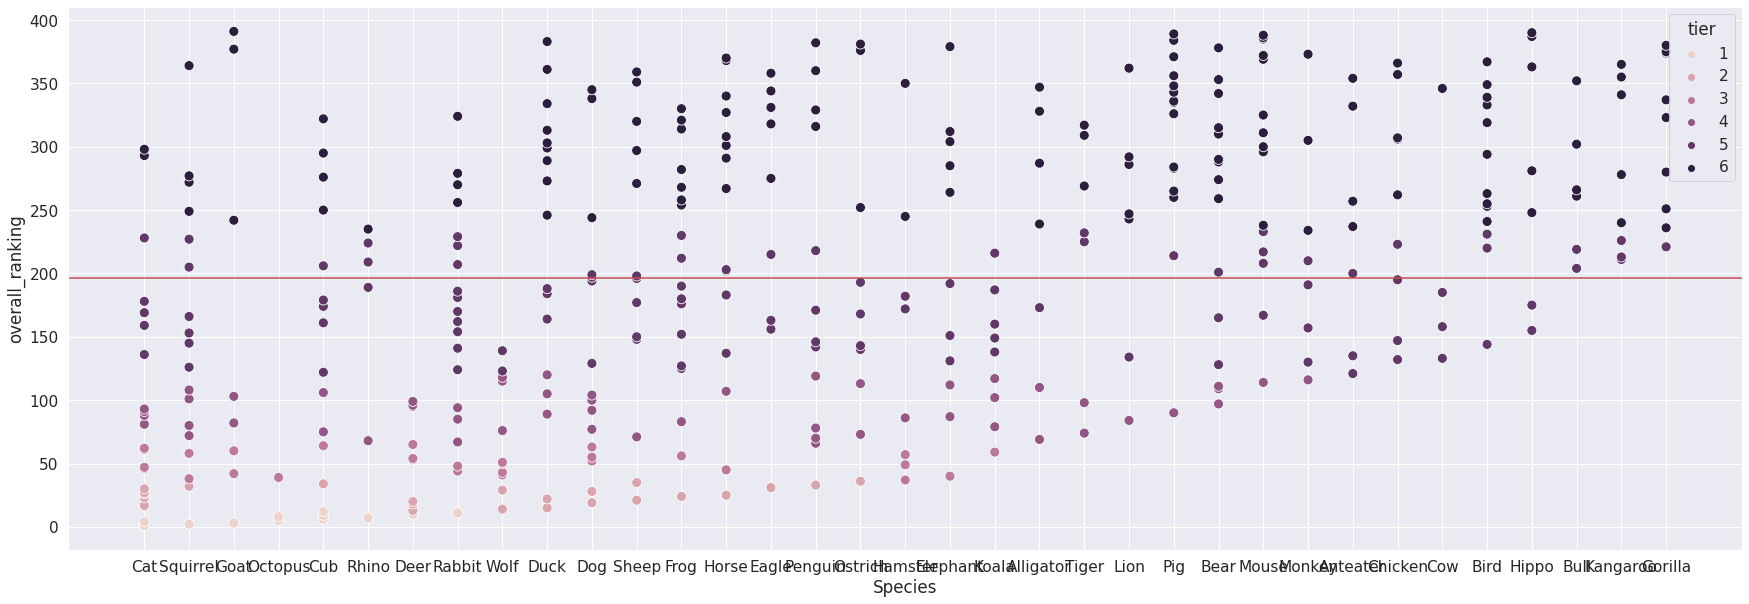

In [24]:
plt.figure(figsize=(30, 10))
plt.axhline(overall_mean, color='r')
sns.scatterplot(x="Species", y='overall_ranking', hue='tier', s=100, data=combined_df)

Although Octopuses seem to be ranking highly in part due to the low amount of Octopuses amongst the villagers. 
Interesting trend can be observed, there exists a ranking cap for low ranking speices, for example, none of the Gorilla villagers have a ranking lower than 200, it is heavily skewed, and not normally distributed.  Indicating a clear non-preference for certain species by the playerbase. 

### 3. Personality

In [25]:
combined_df.Personality.value_counts()

Lazy          60
Normal        59
Snooty        55
Jock          55
Cranky        55
Peppy         49
Smug          34
Big Sister    24
Name: Personality, dtype: int64

In [26]:
# creating value counts dataframe for each personality type
personality_ranking = combined_df.groupby('Personality').mean()['overall_ranking'].to_frame().reset_index().sort_values('overall_ranking')

<AxesSubplot:xlabel='Personality', ylabel='overall_ranking'>

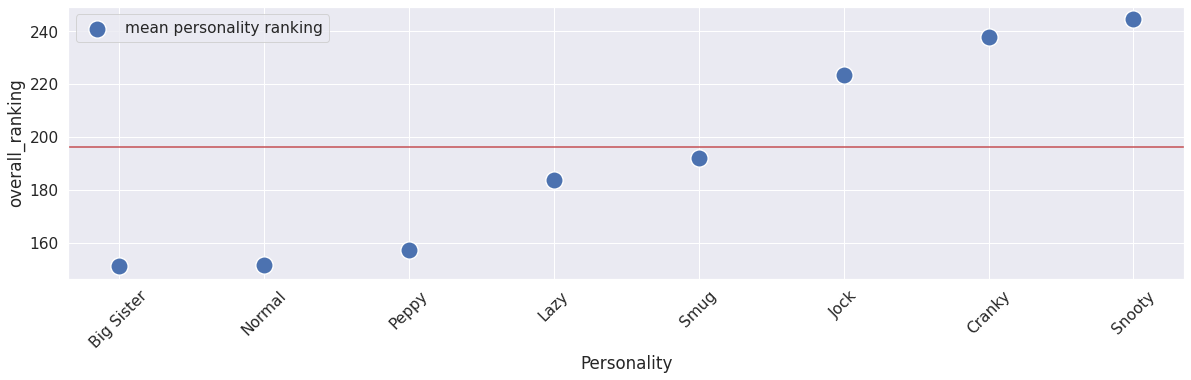

In [27]:
plt.figure(figsize=(20,5))
sns.set(font_scale=1.4)
plt.xticks(rotation=45)
plt.axhline(overall_mean, color='r')
sns.scatterplot(x='Personality', y="overall_ranking", data=personality_ranking,label='mean personality ranking', s=300)

The playerbase seems to have a preference for Big sister, Normal, Peppy and sometimes Lazy type villagers.
While they dislike Cranky, Jock and Snooty villagers. 

<AxesSubplot:xlabel='Personality', ylabel='overall_ranking'>

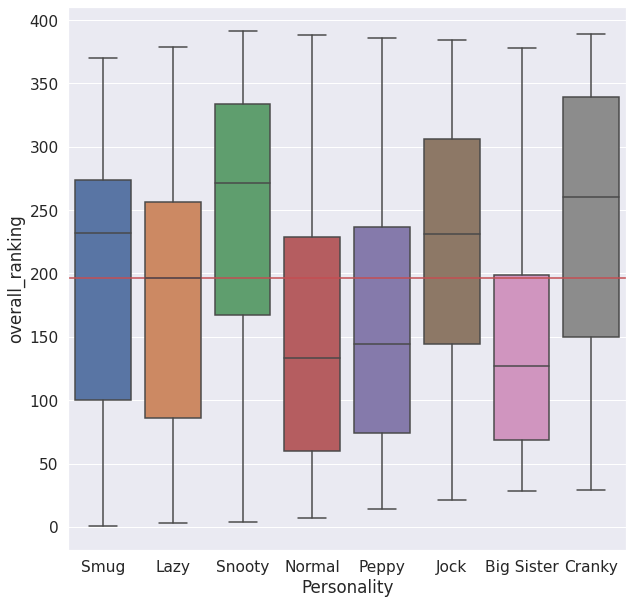

In [28]:
plt.figure(figsize=(10, 10))
plt.axhline(overall_mean, color='r')
sns.boxplot(x="Personality", y='overall_ranking', data=combined_df)

There seems to be a clear preference for Big Sister, Peppy and Normal Personality villagers, they have means below overall mean. Rankings are fairly normally distributed except for Smug villagers. On the other hand, Cranky and Snooty both have a mean clearly above the overall mean.

In [29]:
pd.pivot_table(combined_df, index = 'tier', values = 'Catchphrase', columns="Personality", aggfunc='count')

Personality,Big Sister,Cranky,Jock,Lazy,Normal,Peppy,Smug,Snooty
tier,,,,,,,,
1,NaN,NaN,NaN,4.0,4.0,NaN,2.0,2.0
2,1.0,2.0,2.0,4.0,6.0,6.0,2.0,1.0
3,5.0,4.0,3.0,2.0,8.0,4.0,2.0,1.0
4,6.0,5.0,5.0,9.0,8.0,10.0,6.0,6.0
5,8.0,13.0,18.0,19.0,19.0,16.0,5.0,15.0
6,4.0,31.0,27.0,22.0,14.0,13.0,17.0,30.0


### 4. Style

In [30]:
# generating value counts dataframe for each style type
style_ranking1 = combined_df.groupby('Style 1').mean()['overall_ranking'].to_frame().reset_index().sort_values('overall_ranking')
style_ranking2 = combined_df.groupby('Style 2').mean()['overall_ranking'].to_frame().reset_index().sort_values('overall_ranking')

In [31]:
# combining the 2 style columns and finding a mean
style_ranking = style_ranking1.copy()
style_series = (style_ranking1['overall_ranking'] + style_ranking2['overall_ranking'])/2
style_ranking["overall_ranking"] = style_series

In [32]:
style_ranking

,Style 1,overall_ranking
2,Cute,138.013313
5,Simple,186.501926
3,Elegant,209.923611
1,Cool,216.789133
4,Gorgeous,219.507797
0,Active,226.170000


<AxesSubplot:xlabel='Style 1', ylabel='overall_ranking'>

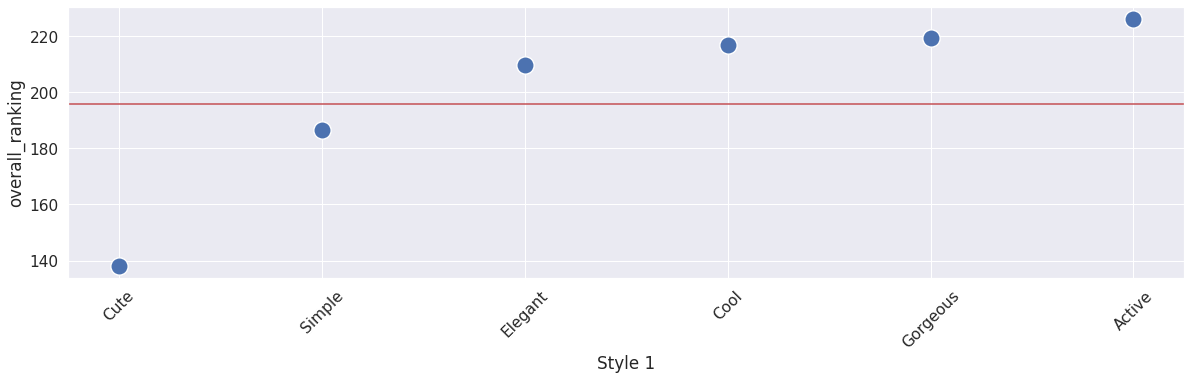

In [33]:
plt.figure(figsize=(20,5))
sns.set(font_scale=1.4)
plt.xticks(rotation=45)
plt.axhline(overall_mean, color='r')
sns.scatterplot(x='Style 1', y="overall_ranking", data=style_ranking, s=300)

A very clear preference for Cute styled villagers. Simple Styled Villagers have a ranking mean just about equal to the overall mean, while other style villagers have a slightly above overall mean mean. 

Text(0.5, 1.0, 'Style 2')

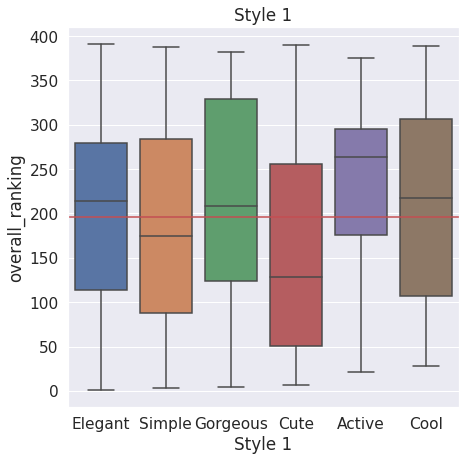

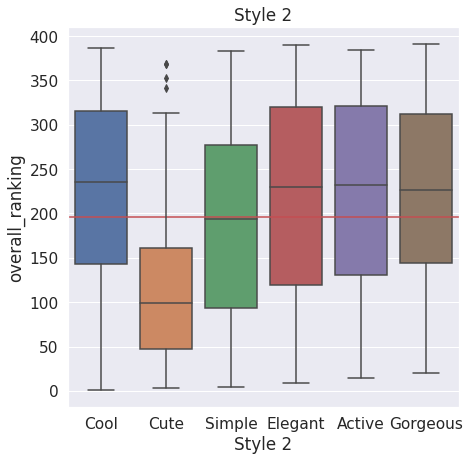

In [34]:
plt.figure(figsize=(7, 7))
plt.axhline(overall_mean, color='r')
sns.boxplot(x="Style 1", y='overall_ranking', data=combined_df)
plt.title('Style 1')
plt.figure(figsize=(7, 7))
plt.axhline(overall_mean, color='r')
sns.boxplot(x="Style 2", y='overall_ranking', data=combined_df)
plt.title('Style 2')

The clear preference is Cute style dressing, in both Style columns. In particular, in Style 2 column Cute Styled Villagers have a higher concetration in lower rankings. Other styles seem to have a fairly normally distributed ranking, with the exception of Active Style Villagers in Style 1, right skewed, but the ranking mean is significantly above the overall ranking mean.  

In [35]:
pd.pivot_table(combined_df, index = 'tier', values = 'Catchphrase', columns="Style 1", aggfunc='count')

Style 1,Active,Cool,Cute,Elegant,Gorgeous,Simple
tier,,,,,,
1,NaN,NaN,3.0,2.0,1.0,6.0
2,2.0,2.0,8.0,1.0,2.0,9.0
3,3.0,7.0,8.0,5.0,NaN,6.0
4,2.0,11.0,11.0,7.0,6.0,18.0
5,15.0,17.0,14.0,17.0,11.0,39.0
6,28.0,31.0,19.0,22.0,18.0,40.0


In [36]:
pd.pivot_table(combined_df, index = 'tier', values = 'Catchphrase', columns="Style 2", aggfunc='count')

Style 2,Active,Cool,Cute,Elegant,Gorgeous,Simple
tier,,,,,,
1,NaN,2.0,7.0,1.0,NaN,2.0
2,2.0,2.0,6.0,2.0,1.0,11.0
3,2.0,3.0,10.0,3.0,2.0,9.0
4,8.0,7.0,13.0,8.0,8.0,11.0
5,13.0,15.0,18.0,15.0,18.0,34.0
6,25.0,30.0,8.0,27.0,25.0,43.0


# Conclusion
We may come to the conclusion, that the following attributes contribute to a villager's popularity:
- Gender: Despite Female Villagers having in general better popularity, this is likely due to the overwheling prescence of male villagers in the lowest tier. Other than the lowest tier, Male villagers in general perform slightly better.
- Species: Octopus, Wolf, Deer and Cat villagers perform the best. 
- Personality: Big Sister, Normal and Peppy villagers are in general the most popular. 
- Style: Cute Style villagers are very clearly the most popular